# Vehicle Model

Everything is same but the vehicle model compared to the double integrator case.

Dubins Car Dynamics with the state vector $(x_t, y_t, \theta_t)$ and control vector $(v_t, \phi_t)$



\begin{equation}
\begin{aligned}
x_{t+1} &= x_{t} + (v_t \cos \theta_t)\delta \\
y_{t+1} &= y_{t} + (v_t \sin \theta_t)\delta \\
\theta_{t+1} &= \theta_{t} + (\frac{v_t}{L} \tan \phi)\delta
\end{aligned}
\end{equation}

In [1]:
import torch
import numpy as np
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"

### Dubins Car Model Parameters ##
L = 0.5 # Wheelbase
DELTA_Time   = 0.1 # For integrator
x_0 = torch.FloatTensor([0, 0, 0]).to(DEVICE)

off_set = 0.1
Phi_SAT_min = -np.pi/2 + off_set
Phi_SAT_max = np.pi/2 - off_set

IF_USE_ATAN = False

In [2]:
N_t = 20 # Time horizon
N_u = 2  # dimension of the control input.
N_x = 3  # dimension of the state space.
N_smpl = 10000 # MPPI 

# Functions and other utility for simulation

In [3]:
### Simulate the multiple trajectories ###
def calculate_state_trajectories(x_0, U_tensor, if_use_atan):
    
    '''
    global parameters:
    L = 0.2 # Wheelbase
    DELTA_Time       = 0.1 # For integrator
    STEER_SATURATION = 1.0
    STEER_FACTOR     = 0.1
    
    given:
    x_0 initial state with size (3)
    U_tensor: N_path, M_destination, N_time, N_u, N_smpl
    
    return:
    XX_tensor: N_path, M_destination, N_time, N_x, N_smpl
    '''
    
    ### Get the shape of the input tensor ###
    N_t, N_u, N_smpl = U_tensor.size()
    
    #U_tensor = U_tensor.permute()
    
    ### Initialize the state value ###
    X_t = x_0.unsqueeze(0).repeat(N_smpl, 1).to(DEVICE)
    
    XX_tensor = []
    for t in range(N_t):
        U_t = U_tensor[t,:,:]   #.permute(0,1,3,2).unsqueeze(-1)
        
        # Control
        
        if if_use_atan:
            V_t   = U_t[0,:]
            #V_t   = torch.clamp(V_t, 0 ,2)
            U_2 = U_t[1,:]

            # State 
            X_coord_t = X_t[:,0]
            Y_coord_t = X_t[:,1]
            Theta_t   = X_t[:,2]

            # State Transition
            X_t[:,0] +=  V_t * torch.cos(Theta_t) * DELTA_Time
            X_t[:,1] +=  V_t * torch.sin(Theta_t) * DELTA_Time
            X_t[:,2] +=  V_t / L * torch.tan(torch.atan(U_2)) * DELTA_Time
            
            
        else:
            V_t   = U_t[0,:]
            #V_t   = torch.clamp(V_t, 0 ,2)
            Phi_t = torch.clamp(U_t[1,:], Phi_SAT_min, Phi_SAT_max)
            
            # State 
            X_coord_t = X_t[:,0]
            Y_coord_t = X_t[:,1]
            Theta_t   = X_t[:,2]

            # State Transition
            X_t[:,0] +=  V_t * torch.cos(Theta_t) * DELTA_Time
            X_t[:,1] +=  V_t * torch.sin(Theta_t) * DELTA_Time
            X_t[:,2] +=  V_t / L * torch.tan(Phi_t) * DELTA_Time

        XX_tensor.append(X_t.clone())
        
    XX_tensor  = torch.stack(XX_tensor, -1) #.permute(0,1, 5, 2, 3, 4)
    
    return XX_tensor
    

UU = torch.randn(N_t, N_u, N_smpl).to(DEVICE)

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
XX = calculate_state_trajectories(x_0, UU, True)

In [4]:
class CostCalculator:
    def __init__(self, X_goal):
        self.X_goal = X_goal
        
        self.Q_running = torch.FloatTensor([[1, 0, 0],[0, 1, 0],[0, 0, 0]]).to(DEVICE)
        self.R_running = torch.FloatTensor([[.1, 0],[0, .1]]).to(DEVICE)

        self.Q_terminal = torch.FloatTensor([[1, 0, 0],[0, 1, 0],[0, 0, 0]]).to(DEVICE)*1
        self.R_terminal = torch.FloatTensor([[.1, 0],[0, .1]]).to(DEVICE)
        
        self.Box_to_Avoid = {}
        self.Box_to_Avoid.update({'LB_X':4})
        self.Box_to_Avoid.update({'UB_X':6})
        self.Box_to_Avoid.update({'LB_Y':4})
        self.Box_to_Avoid.update({'UB_Y':8})
        self.GAP = 0.2
        self.W_penalty = 10000
        
        
    def calcualte(self, XX, UU):
        
        N_smpl, N_state, N_time = XX.size()
        
        ### Repeat and reshaping the tensors ###
        XX_goal = self.X_goal.unsqueeze(-1)
        XX_goal = XX_goal.repeat(N_smpl, 1, N_time)
        
        ##################################
        ### Calculate the running cost ###
        ##################################
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        EE = (XX - XX_goal).unsqueeze(-1).permute(0,2,1,3)
        EE_T = EE.permute(0,1,3,2)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE))
        ### Control Cost: u_T*R*u ###
        RR = self.R_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        UU = UU.permute(2, 0, 1).unsqueeze(-1)
        UU_T = UU.permute(0,1,3,2)
        UURRUU = torch.matmul(UU_T, torch.matmul(RR, UU))
        ### Indicator in the obstacle space ###
        XX_x = XX[:, 0, :]
        XX_y = XX[:, 1, :]
        
        LB_X = self.Box_to_Avoid['LB_X']
        UB_X = self.Box_to_Avoid['UB_X']
        LB_Y = self.Box_to_Avoid['LB_Y']
        UB_Y = self.Box_to_Avoid['UB_Y']
        GAP  = self.GAP
        W_penalty = self.W_penalty
        
        If_Within_Obstacle = (XX_x > LB_X-GAP).type(torch.float)*(XX_x < UB_X+GAP).type(torch.float)*(XX_y > LB_Y-GAP).type(torch.float)*(XX_y < UB_Y+GAP).type(torch.float)
        If_Within_Obstacle = If_Within_Obstacle.unsqueeze(-1)
        
        ### Running cost L tensor ###
        #LL = EEQQEE.squeeze() + UURRUU.squeeze() + W_penalty * If_Within_Obstacle.squeeze()
        LL = EEQQEE.squeeze() +  W_penalty * If_Within_Obstacle.squeeze()
        #LL = W_penalty * If_Within_Obstacle.squeeze()
        
        ###################################
        ### Calculate the terminal cost ###
        ###################################
        XX_terminal  = XX[:,:,-1].unsqueeze(-1)
        XX_goal = XX_goal[:,:,-1].unsqueeze(-1)
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        EE = (XX_terminal - XX_goal)
        EE_T = EE.permute(0,2,1)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE)).squeeze()
        
        
        UU_terminal = UU[:,-1,:,:].squeeze().unsqueeze(-1)
        RR = self.R_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        UU_terminal_T = UU_terminal.permute(0, 2, 1)
        UURRUU = torch.matmul(UU_terminal_T, torch.matmul(RR, UU_terminal)).squeeze()
        
        FF = EEQQEE.squeeze() #+ #1*UURRUU.squeeze()
        
        cost = torch.mean(LL, 1) + FF
                
        return cost

UU = torch.randn(N_t, N_u, N_smpl).to(DEVICE)

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
XX = calculate_state_trajectories(x_0, UU, True)

X_goal = torch.FloatTensor([[10, 10, 0]]).to(DEVICE)     
cost_calculator = CostCalculator(X_goal)
cost = cost_calculator.calcualte(XX, UU)


We consider the two alternative destinations: (4, 10) and (5, 5),
in addition to the primary desination (10, 10).

And the usual quadratic cost are used with
\begin{equation}
C(x, u) = (x - x_\text{tgt})^\top Q (x - x_\text{tgt}) + u^\top R u
\end{equation}

In [5]:
import tqdm



def run_sim(if_use_atan):
    
    ### Simulate the random trajctories ###
    x_0 = torch.zeros(N_x).to(DEVICE)
    X_goal = torch.FloatTensor([[8, 8, 0]]).to(DEVICE)      
    cost_calculator = CostCalculator(X_goal)

    LAMBDA = 1.0 # MPPI Param
    
    x_t = x_0 # Initizlize the state for SIM
    T_sim = 3000

    x_sim_result = []
    u_sim_result = []
    random_u_variance_result = []
    mean_energy_result = []
    variance_energy_result = []

    for t in tqdm.tqdm(range(T_sim)):
        
        ### Sampling and construct the control table ###
        UU = torch.randn(N_t, N_u, N_smpl).to(DEVICE)
        
        ### Simulate the random trajctories for Optimizaiton (MPPI) ###
        XX = calculate_state_trajectories(x_t, UU, if_use_atan)
        
        ### Calcualte the costs of state trajectories ###
        J = cost_calculator.calcualte(XX, UU)
        
        ### Stochastic optimziaiton (MPPI) ####
        # Now get the weight for MPPI 
        energy = torch.exp(-1/LAMBDA*(J-J.min()))
        weight_mppi = energy / torch.sum(energy)
        
        
        
        
        # Get weighted sum for u_t
        U_first_samples = UU[0,:,:].squeeze() # <--- epsilon
        
        ### Monitoring variables ###
        ### epsilon * w, where w = energy
        ### ------------------
        ###  average(energy) #
        
        weighted_controls = U_first_samples*energy/(energy.mean())
        var_control = weighted_controls.var().item()
        random_u_variance_result.append(var_control)
        
        mean_energy_result.append(energy.mean().item())
        variance_energy_result.append(energy.var().item())
        
        u_t  = torch.sum(U_first_samples*weight_mppi,1)
        
        ### Use it with the system ###
        if if_use_atan:
            # Control
            v_t   = u_t[0]
            #v_t   = torch.clamp(v_t, 0 ,2)
            u2_t = u_t[1]

            # State 
            x_coord_t = x_t[0]
            y_coord_t = x_t[1]
            theta_t   = x_t[2]

            # State Transition
            x_t[0] +=  v_t * torch.cos(theta_t) * DELTA_Time
            x_t[1] +=  v_t * torch.sin(theta_t) * DELTA_Time
            x_t[2] +=  v_t / L * torch.tan(torch.atan(u2_t)) * DELTA_Time
            
            #print(theta_t)
            
        else:
            # Control
            v_t   = u_t[0]
            #v_t   = torch.clamp(v_t, 0 ,2)
            phi_t = torch.clamp(u_t[1], Phi_SAT_min, Phi_SAT_max)

            # State 
            x_coord_t = x_t[0]
            y_coord_t = x_t[1]
            theta_t   = x_t[2]

            # State Transition
            x_t[0] +=  v_t * torch.cos(theta_t) * DELTA_Time
            x_t[1] +=  v_t * torch.sin(theta_t) * DELTA_Time
            x_t[2] +=  v_t / L * torch.tan(phi_t) * DELTA_Time
            
            #print('phi_t',phi_t, 'theta_t', theta_t)
        
        ### Append data for plotting ###
        x_sim_result.append([x_t.cpu().numpy().copy()])
        u_sim_result.append([u_t.cpu().numpy().copy()])
        
        #print(x_t)
        #print(X_goal)
        
        if torch.linalg.norm(x_t[:2] - X_goal[0][:2]) <= L:
            print('Reached the target!')
            break
        
        #print(energy.var(), energy.max(), energy.min())

    x_sim_result = np.vstack(x_sim_result)
    u_sim_result = np.vstack(u_sim_result)
    random_u_variance_result = np.array(random_u_variance_result) 
    mean_energy_result = np.array(mean_energy_result)
    variance_energy_result = np.array(variance_energy_result)
    
    return x_sim_result, u_sim_result, random_u_variance_result, mean_energy_result, variance_energy_result

  0%|▏                                                                                | 8/3000 [00:00<00:37, 79.80it/s]

Reached the target!


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:37<00:00, 79.88it/s]
No handles with labels found to put in legend.
No handles with labels found to put in legend.


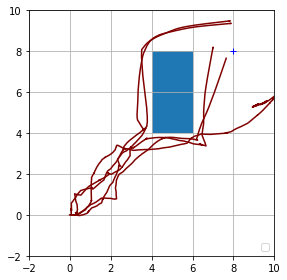

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
X_goal = torch.FloatTensor([[8, 8, 0]]).to(DEVICE)     


fig, ax = plt.subplots()

for i in range(5):
    x_sim_result, u_sim_result, random_u_variance_result, mean_energy_result, variance_energy_result = run_sim(False)

    x = x_sim_result[:,0]
    y = x_sim_result[:,1]
    theta =x_sim_result[:,2]

    ax.plot(x, y, color='maroon')
    
### Add goal positions ###
if DEVICE != "cpu":
    np_X_goal = X_goal.cpu().numpy()
else:
    np_X_goal = X_goal.numpy()

### Add goal positions ###
ax.plot(np_X_goal[0,0], np_X_goal[0,1], 'b+')

### Add the rect. obs. ###
LB_X = cost_calculator.Box_to_Avoid['LB_X']
UB_X = cost_calculator.Box_to_Avoid['UB_X']
LB_Y = cost_calculator.Box_to_Avoid['LB_Y']
UB_Y = cost_calculator.Box_to_Avoid['UB_Y']

ax.add_patch(Rectangle((LB_X, LB_Y), UB_X - LB_X, UB_Y - LB_Y))


    
    
ax.grid()
ax.legend()
ax.set_aspect('equal')
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)
plt.legend(loc='lower right')
plt.tight_layout()
fig.savefig('figures/figure3_no_inverseion.pdf', format='pdf')
fig.savefig('figures/figure3_no_inverseion.png')
plt.show()

  0%|▏                                                                                | 9/3000 [00:00<00:36, 81.02it/s]

Reached the target!


  0%|▏                                                                                | 9/3000 [00:00<00:36, 81.80it/s]

Reached the target!


  0%|▏                                                                                | 8/3000 [00:00<00:37, 79.57it/s]

Reached the target!


  0%|▏                                                                                | 8/3000 [00:00<00:37, 79.17it/s]

Reached the target!


  7%|█████▊                                                                         | 220/3000 [00:02<00:34, 79.67it/s]
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Reached the target!


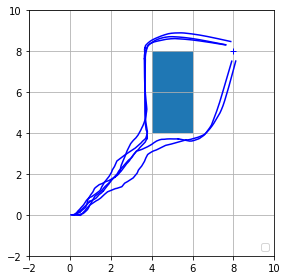

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
X_goal = torch.FloatTensor([[8, 8, 0]]).to(DEVICE)     


fig, ax = plt.subplots()

for i in range(5):
    x_sim_result, u_sim_result, random_u_variance_result, mean_energy_result, variance_energy_result = run_sim(True)

    x = x_sim_result[:,0]
    y = x_sim_result[:,1]
    theta =x_sim_result[:,2]

    ax.plot(x, y, 'b-')
    
### Add goal positions ###
if DEVICE != "cpu":
    np_X_goal = X_goal.cpu().numpy()
else:
    np_X_goal = X_goal.numpy()

### Add goal positions ###
ax.plot(np_X_goal[0,0], np_X_goal[0,1], 'b+')

### Add the rect. obs. ###
LB_X = cost_calculator.Box_to_Avoid['LB_X']
UB_X = cost_calculator.Box_to_Avoid['UB_X']
LB_Y = cost_calculator.Box_to_Avoid['LB_Y']
UB_Y = cost_calculator.Box_to_Avoid['UB_Y']

ax.add_patch(Rectangle((LB_X, LB_Y), UB_X - LB_X, UB_Y - LB_Y))

    
ax.grid()
ax.legend()
ax.set_aspect('equal')
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)
plt.legend(loc='lower right')
plt.tight_layout()
fig.savefig('figures/figure3_with_inverseion.pdf', format='pdf')
fig.savefig('figures/figure3_with_inverseion.png')
plt.show()